In [2]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="OE3Jg3u3F6BPO27NPQFe")
project = rf.workspace("takoyati").project("cigarette-vape-detection")
version = project.version(14)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...


In [7]:
import os
from PIL import Image
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import shutil

In [10]:

# 경로 설정
train_dir = '/content/Cigarette-Vape-Detection-14/valid'
labels_dir = os.path.join(train_dir, 'labels')
images_dir = os.path.join(train_dir, 'images')
vape_dir = os.path.join(train_dir, 'vape')
cigarette_dir = os.path.join(train_dir, 'cigarette')

# vape, cigarette 폴더 생성
os.makedirs(vape_dir, exist_ok=True)
os.makedirs(cigarette_dir, exist_ok=True)

# 파일 이동
for label_file in os.listdir(labels_dir):
    with open(os.path.join(labels_dir, label_file), 'r') as f:
        label = int(f.read().split()[0])
        image_name = os.path.splitext(label_file)[0]
        image_path = os.path.join(images_dir, image_name + '.jpg')

        if label == 0:
            dst_dir = vape_dir
        else:
            dst_dir = cigarette_dir

        shutil.copy(image_path, os.path.join(dst_dir, image_name + '.jpg'))


In [9]:
# ImageDataGenerator 설정
data_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

# train_generator 생성
train_generator = data_generator.flow_from_directory(
    '/content/Cigarette-Vape-Detection-14/train/rr',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
)
validation_generator = data_generator.flow_from_directory(
    '/content/Cigarette-Vape-Detection-14/valid/rr',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation'
)
test_generator = data_generator.flow_from_directory(
    '/content/Cigarette-Vape-Detection-14/test/rr',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
)


Found 12114 images belonging to 2 classes.
Found 231 images belonging to 2 classes.
Found 577 images belonging to 2 classes.


In [11]:
base_model= tf.keras.applications.efficientnet_v2.EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(2, activation='softmax')(x)
EfficientNetV2B0_model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False

EfficientNetV2B0_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=EfficientNetV2B0_model.fit(train_generator, epochs=30,validation_data=validation_generator)

473176280/473176280 [==============================] - 24s 0us/step
Epoch 1/30
95/95 [==============================] - 192s 2s/step - loss: 0.6827 - accuracy: 0.5661 - val_loss: 0.7287 - val_accuracy: 0.5325
Epoch 2/30
95/95 [==============================] - 137s 1s/step - loss: 0.6705 - accuracy: 0.5899 - val_loss: 0.6914 - val_accuracy: 0.5498
Epoch 3/30
95/95 [==============================] - 137s 1s/step - loss: 0.6626 - accuracy: 0.6029 - val_loss: 0.6916 - val_accuracy: 0.5455
Epoch 4/30
95/95 [==============================] - 137s 1s/step - loss: 0.6476 - accuracy: 0.6266 - val_loss: 0.6886 - val_accuracy: 0.5671
Epoch 5/30
95/95 [==============================] - 137s 1s/step - loss: 0.6478 - accuracy: 0.6246 - val_loss: 0.6861 - val_accuracy: 0.5671
Epoch 6/30
95/95 [==============================] - 137s 1s/step - loss: 0.6391 - accuracy: 0.6375 - val_loss: 0.6663 - val_accuracy: 0.6450
Epoch 7/30
95/95 [==============================] - 137s 1s/step - loss: 0.6307 - accu

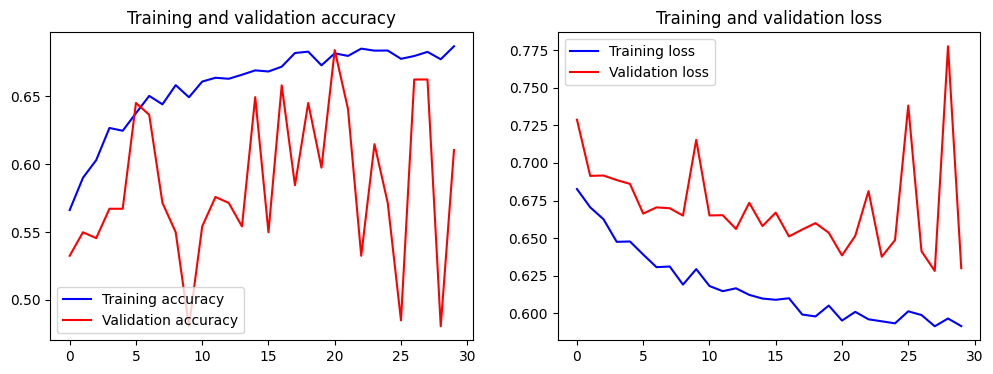

5/5 [==============================] - 13s 3s/step - loss: 0.5878 - accuracy: 0.6811
Test Accuracy: 0.6811091899871826
5/5 [==============================] - 12s 1s/step


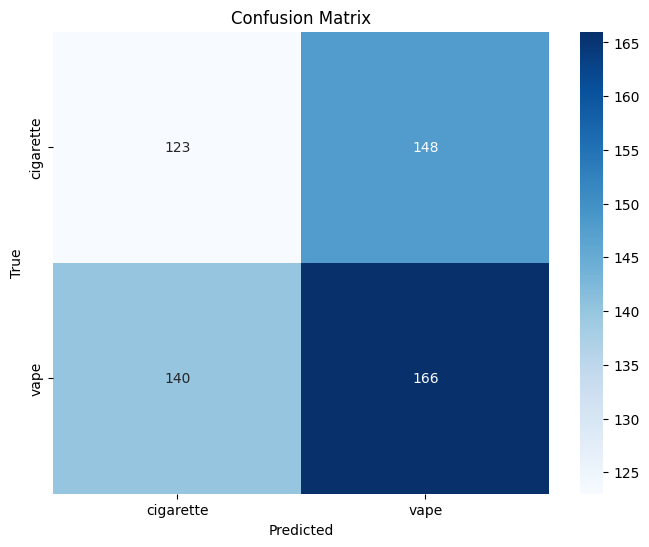

              precision    recall  f1-score   support

   cigarette       0.47      0.45      0.46       271
        vape       0.53      0.54      0.54       306

    accuracy                           0.50       577
   macro avg       0.50      0.50      0.50       577
weighted avg       0.50      0.50      0.50       577



In [12]:
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = EfficientNetV2B0_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = EfficientNetV2B0_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)